# Analysis: Logistic Regression for AfterMarket

Goal: Use logistic regression to create a model for the aftermarket feature.

In [1]:
import pandas as PD
import numpy as NP
import sklearn.preprocessing as PP
import sklearn.model_selection as MS
import sklearn.linear_model as LM
import statsmodels.stats as ST  # .outliers_influence.variance_inflation_factor
#from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

import matplotlib.pyplot as MP
import seaborn as SB
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Prepare Target & Features

In [3]:
FEATURE_FILE = '../data/merge_feature.csv'
full_df = PD.read_csv(FEATURE_FILE)
full_df.head()
full_df.info()

,set_no,name,price_store,price_used,aftermarket,popularity,group,year,total_parts,number_parts,number_colors,scolor_1st,scolor_2nd
0,858-1,Auto Engines,NaN,51.0,NaN,9.0,Technical,1980.0,242,46,5,Blue,Gray
1,1591-1,Danone Delivery Truck,NaN,28.0,NaN,NaN,Modern day,1980.0,40,19,4,White,Blue
2,1592-1,Town Square - Castle Scene,NaN,235.0,NaN,19.2,Modern day,1980.0,495,133,10,Black,Yellow
3,1651-2,Maersk Line Container Lorry,NaN,444.0,NaN,5.0,Modern day,1980.0,305,66,9,Blue,Gray
4,3634-1,Charlie Crow's Carry-All,NaN,14.0,NaN,3.0,Junior,1980.0,18,15,7,Yellow,Green


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5303 entries, 0 to 5302
Data columns (total 13 columns):
set_no           5303 non-null object
name             5303 non-null object
price_store      4178 non-null float64
price_used       4968 non-null float64
aftermarket      4034 non-null float64
popularity       4560 non-null float64
group            5303 non-null object
year             5303 non-null float64
total_parts      5303 non-null int64
number_parts     5303 non-null int64
number_colors    5303 non-null int64
scolor_1st       5294 non-null object
scolor_2nd       5301 non-null object
dtypes: float64(5), int64(3), object(5)
memory usage: 538.7+ KB


In [4]:
# filter out rows without aftermarket

full_df = full_df.loc[full_df['aftermarket'].isna()==False]
full_df.shape

(4034, 13)

In [5]:
# target series

target_sr = full_df['aftermarket'].apply(lambda f: 1 if f > 0 else 0)
target_sr.shape

(4034,)

In [6]:
# feature dataframe with one-hot encoding

feature_ls = ['group', 'year', 'total_parts', 'number_parts', 'number_colors', 'scolor_1st', 'scolor_2nd']
feature_cat_df = full_df[feature_ls]

feature_df = PD.get_dummies(feature_cat_df, drop_first= True, 
               columns=['group', 'scolor_1st', 'scolor_2nd'])
feature_df.shape
feature_df.columns

(4034, 31)

Index(['year', 'total_parts', 'number_parts', 'number_colors',
       'group_Constraction', 'group_Girls', 'group_Historical', 'group_Junior',
       'group_Licensed', 'group_Model making', 'group_Modern day',
       'group_Racing', 'group_Technical', 'scolor_1st_Blue',
       'scolor_1st_Brown', 'scolor_1st_Gray', 'scolor_1st_Green',
       'scolor_1st_Red', 'scolor_1st_Tan', 'scolor_1st_Transparent',
       'scolor_1st_White', 'scolor_1st_Yellow', 'scolor_2nd_Blue',
       'scolor_2nd_Brown', 'scolor_2nd_Gray', 'scolor_2nd_Green',
       'scolor_2nd_Red', 'scolor_2nd_Tan', 'scolor_2nd_Transparent',
       'scolor_2nd_White', 'scolor_2nd_Yellow'],
      dtype='object')

In [7]:
# check for colinearity

vif = [VIF(feature_df.values, i) for i in range(feature_df.shape[1])]
list(zip(feature_df.columns, vif))

[('year', 21.135672947572576),
 ('total_parts', 4.796059308157447),
 ('number_parts', 13.903788876033488),
 ('number_colors', 16.324920771425866),
 ('group_Constraction', 1.7011001518284976),
 ('group_Girls', 1.6705792906301138),
 ('group_Historical', 1.5814468790204115),
 ('group_Junior', 1.2016984564034758),
 ('group_Licensed', 2.7625571162115174),
 ('group_Model making', 1.6875179289104076),
 ('group_Modern day', 2.4665477605525536),
 ('group_Racing', 1.3751799134677298),
 ('group_Technical', 1.6600275091034387),
 ('scolor_1st_Blue', 1.1707298131211683),
 ('scolor_1st_Brown', 1.2060011307707863),
 ('scolor_1st_Gray', 1.9220243054770545),
 ('scolor_1st_Green', 1.1227920042642958),
 ('scolor_1st_Red', 1.2728972079528764),
 ('scolor_1st_Tan', 1.1464997253676372),
 ('scolor_1st_Transparent', 1.0398264659017975),
 ('scolor_1st_White', 1.956487332208143),
 ('scolor_1st_Yellow', 1.260814169136973),
 ('scolor_2nd_Blue', 1.3788930579158816),
 ('scolor_2nd_Brown', 1.2493519771810162),
 ('scol

## Split Test & Standardize

In [8]:
TEST_SPLIT = 0.2
SEED = 1

In [36]:
y_train, y_test, X_train, X_test = MS.train_test_split(target_sr, feature_df, 
                                                       stratify=feature_df['year'], 
                                                       test_size=TEST_SPLIT, random_state=SEED)

y_train.shape
y_test.shape 
X_train.shape
X_test.shape

(3227,)

(807,)

(3227, 31)

(807, 31)

In [10]:
# fit the scalers based on the training set
# must include all features, including one-hot encoded ones
# target variable does not need to be transformed

scaler = PP.StandardScaler()
scaler.fit(X_train)
scaler.mean_.shape

StandardScaler(copy=True, with_mean=True, with_std=True)

(31,)

In [11]:
# create standardized feature sets

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std.shape

(3227, 31)

[Text(0, 0.5, 'Number of Sets'), Text(0.5, 0, 'Total Parts')]

[Text(0, 0.5, 'Number of Sets'), Text(0.5, 0, 'Standard Total Parts')]

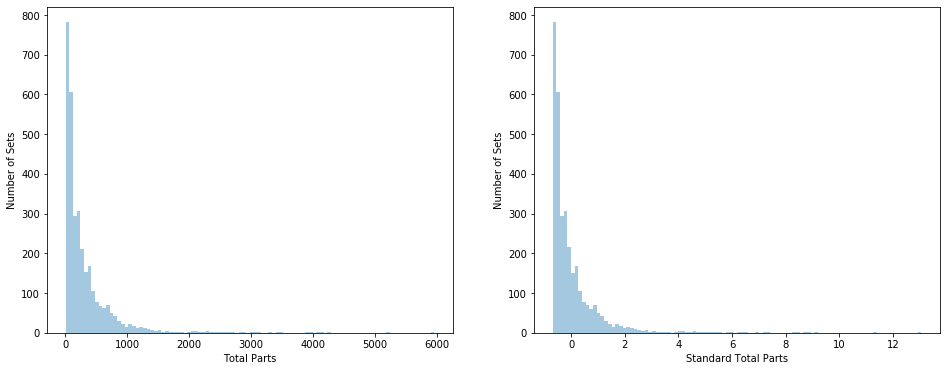

In [12]:
fig, axs = MP.subplots(1, 2, figsize=(16, 6))
parts_idx = X_train.columns.get_loc('total_parts')

SB.distplot(X_train['total_parts'], ax=axs[0], kde=False, bins=100)
axs[0].set(xlabel='Total Parts', ylabel='Number of Sets')

SB.distplot(X_train_std[:, parts_idx], ax=axs[1], kde=False, bins=100)
axs[1].set(xlabel='Standard Total Parts', ylabel='Number of Sets')

MP.show()

In [ ]:
# can run PCA after standardazing 





## Setup Algorithm

In [13]:
algorithm_ls = []
alpha_ls = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

def get_adjusted_rsquared(rsquared, size, num_cols):
    adj_rsq = 1 - (1 - rsquared) * (size -1) / (size - num_cols -1)
    return adj_rsq

### Vanilla Linear

In [14]:
# get main result
# can't use test set until model is chosen

linreg = LM.LinearRegression()
linreg.fit(X_train_std, y_train)
linreg.coef_.shape
linreg.intercept_.shape

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

(31,)

()

In [15]:
train_score = linreg.score(X_train_std, y_train)
train_score_adj = get_adjusted_rsquared(train_score, X_train_std.shape[0], X_train_std.shape[1])
train_score_adj

0.24658812133314423

In [16]:
# use cross validation to get error

cv_results = MS.cross_validate(LM.LinearRegression(), X_train_std, y_train, cv=5, return_train_score=True)
cv_results

{'fit_time': array([0.00506091, 0.00527883, 0.02515626, 0.02309608, 0.01161003]),
 'score_time': array([0.00101018, 0.00102615, 0.01189494, 0.00925779, 0.00101113]),
 'test_score': array([0.22203034, 0.22884001, 0.23384887, 0.23787486, 0.24402095]),
 'train_score': array([0.25830666, 0.25757489, 0.25585061, 0.25286372, 0.25367589])}

In [17]:
# compile algorithm results
# ok to use non-adjusted r-sq, use adjusted just for final test

new_dx = {
    'type': 'baseline',
    'lambda': NP.min(alpha_ls) - 0.5 *NP.min(alpha_ls), 
    'cvtrain_score': cv_results['train_score'].mean(),
    'cvtrain_error': cv_results['train_score'].std(),
    'cvtest_score': cv_results['test_score'].mean(),
    'cvtest_error': cv_results['test_score'].std(),
}
algorithm_ls.append(new_dx)
new_dx

{'type': 'baseline',
 'lambda': 5e-05,
 'cvtrain_score': 0.2556543563060515,
 'cvtrain_error': 0.0021196058055061905,
 'cvtest_score': 0.23332300714085114,
 'cvtest_error': 0.007524139893026785}